In [158]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.fft import fft, ifft, fftfreq
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


### Load and create data for FFT and LDA

In [159]:
# Made some edits!
# Load data
leakage_data = pd.read_csv('../../data/Positive_Meters_Data/Aquatrax_SmallLeak.csv')
nonleakage_data = pd.read_csv('../../data/Negative_Meters_Data/Aquatrax_Nonleakage_Data_20accounts.csv')

# Cleaning datasets
nonleakage_data = nonleakage_data.rename({'Usagedate': 'UsageDate', 'Meternumber': 'MeterNumber'}, axis='columns') #rename columns
leakage_data = leakage_data.rename({'Usagedate': 'UsageDate', 'Meternumber': 'MeterNumber'}, axis='columns') #rename columns
leakage_data = leakage_data.iloc[:,:4]

# Combine the datasets
leakage_data['Class'] = 1  # Indicate leakage
nonleakage_data['Class'] = 0  # Indicate non-leakage



combined_data = pd.concat([leakage_data, nonleakage_data])

# Sort by MeterNumber and UsageDate
combined_data.sort_values(by=['MeterNumber', 'UsageDate'], inplace=True)

# Reset index after sorting
combined_data.reset_index(drop=True, inplace=True)

# Create UsageRatio col
combined_data['UsageRatio'] = pd.NA

# Iterate over account numbers
for num in combined_data['AccountNumber'].unique():
    # Pull data for each account number
    subset = combined_data[combined_data['AccountNumber'] == num]
    
    # Count values for each condition
    non_zero_count = (subset['Value'] > 0).sum()
    zero_count = (subset['Value'] == 0).sum()
    
    # Calculate usage ratio (nonzero-to-zero)
    usage_ratio = non_zero_count / zero_count if zero_count != 0 else pd.NA
    combined_data.loc[combined_data['AccountNumber'] == num, 'UsageRatio'] = usage_ratio

# Store usage ratios as df for later
# unique_account_numbers = combined_data['AccountNumber'].unique()
# usage_ratio_vals = combined_data.groupby('AccountNumber')['UsageRatio'].first().reindex(unique_account_numbers).tolist()
unique_account_numbers = combined_data['AccountNumber'].unique()
usage_ratios = combined_data.groupby('AccountNumber')['UsageRatio'].first().values

# # Create a new dataframe usage_ratio_vals
usage_ratio_vals = pd.DataFrame({'AccountNumber': unique_account_numbers, 'UsageRatio': usage_ratios})

combined_data


,AccountNumber,UsageDate,Value,MeterNumber,Class,UsageRatio
0,0050005-28920,01-01-2023 00:00,2,0050005-10450-1,0,0.101412
1,0050005-28920,01-01-2023 01:00,0,0050005-10450-1,0,0.101412
2,0050005-28920,01-01-2023 02:00,0,0050005-10450-1,0,0.101412
3,0050005-28920,01-01-2023 03:00,0,0050005-10450-1,0,0.101412
4,0050005-28920,01-01-2023 04:00,0,0050005-10450-1,0,0.101412
...,...,...,...,...,...,...
299163,5751740-68085,12-31-2022 19:00,1,5751740-10450-1,1,9.37798
299164,5751740-68085,12-31-2022 20:00,0,5751740-10450-1,1,9.37798
299165,5751740-68085,12-31-2022 21:00,1,5751740-10450-1,1,9.37798
299166,5751740-68085,12-31-2022 22:00,2,5751740-10450-1,1,9.37798


In [160]:
#truncate each account number to have same length = threshold
LEN_THRES = 7500
df_account_list = [combined_data[combined_data['AccountNumber'] == number].tail(LEN_THRES) for number in combined_data['AccountNumber'].unique()]
for (idx, df_account) in enumerate(df_account_list):
    if (len(df_account) < LEN_THRES):  #remove account if total number of datapoints below threshold
        dropping_meter_number = df_account.loc[:].reset_index()['MeterNumber'][0]
        combined_data = combined_data.drop(combined_data[combined_data['MeterNumber']==dropping_meter_number].index)
        del df_account_list[idx]
[len(e) for e in df_account_list]  #display number of data points for each account

[7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500,
 7500]

In [161]:
print(len(df_account_list[0]))

7500


In [162]:
#need to run the above block before running this one!!

#list to store pivoted account dataframes
df_account_pivoted_list = []

#conduct fourier transfor on each account
for (idx, df_account) in enumerate(df_account_list):
    df_account['FFT_F'] = fftfreq(len(df_account), 1)
    df_account['FFT_Period'] = 1/df_account['FFT_F']
    df_account['FFT'] = fft(df_account['Value'])
    df_account['FFTA'] = np.abs(df_account['FFT'])

    #only keep periods from 0 to 30
    df_account = df_account.where(df_account['FFT_Period'] <= 100)
    df_account = df_account.where(df_account['FFT_Period'] >= 0)
    df_account = df_account.dropna()
    df_account_list[idx] = df_account

    #pivot each account dataframe
    df_account_pivoted = df_account.pivot(index="AccountNumber", columns='FFT_Period', values='FFTA')
    df_account_pivoted_list.append(df_account_pivoted)

df_account_pivoted_list[0]  #this shows 0 na's in dataframe


FFT_Period,2.000533,2.001067,2.001601,2.002136,2.002670,2.003205,2.003740,2.004276,2.004812,2.005348,...,89.285714,90.361446,91.463415,92.592593,93.750000,94.936709,96.153846,97.402597,98.684211,100.000000
AccountNumber,,,,,,,,,,,,,,,,,,,,,
0050005-28920,124.149343,158.141899,64.938147,77.6017,42.662195,32.74185,56.084477,78.939669,116.762542,58.775317,...,222.945755,104.957595,43.834491,102.684282,90.876485,146.693388,51.57953,105.280971,122.650629,86.775234


In [163]:
# combine all pivoted account dataframes
df_accounts_pivoted = pd.concat(df_account_pivoted_list)

# merge with stored usage ratios
df_accounts_pivoted = pd.merge(df_accounts_pivoted, usage_ratio_vals, on='AccountNumber', how='left')
#df_account_pivoted = pd.concat(usage_ratio_vals)

df_accounts_pivoted


,AccountNumber,2.0005334755934916,2.0010672358591246,2.00160128102482,2.00213561131874,2.0026702269692924,2.003205128205128,2.003740315255143,2.0042757883484765,2.0048115477145148,...,90.36144578313252,91.46341463414635,92.59259259259258,93.74999999999999,94.9367088607595,96.15384615384615,97.4025974025974,98.68421052631578,100.0,UsageRatio
0,0050005-28920,124.149343,158.141899,64.938147,77.601700,42.662195,32.741850,56.084477,78.939669,116.762542,...,104.957595,43.834491,102.684282,90.876485,146.693388,51.579530,105.280971,122.650629,86.775234,0.101412
1,0050015-328466,93.004434,141.689065,73.804858,223.741081,35.797403,180.564034,243.925734,180.280827,67.842767,...,248.921533,213.615960,250.737992,197.550897,254.693141,335.139920,116.371322,358.334267,203.500673,0.469786
2,0050017-668118,120.551459,67.625835,167.578027,64.648633,132.422852,92.543808,146.455887,29.508063,119.969151,...,83.620470,204.722682,37.571468,145.696681,103.068668,108.187932,52.343712,120.073422,155.942757,0.469227
3,0050020-660260,385.779023,315.186462,171.289129,66.388887,133.261003,91.737888,18.871754,71.030641,116.514351,...,46.249502,104.733059,167.594885,55.567388,148.105564,105.135365,9.849864,45.410118,81.773654,0.310706
4,0050100-50430,95.891447,48.473892,61.564863,107.176587,42.742959,142.269649,118.328452,206.675077,35.331375,...,391.669726,159.600859,27.998063,348.113851,241.849429,342.237139,211.462591,572.913887,84.952839,0.721866
5,0050110-26,1523.172081,283.062982,419.868545,375.451790,1019.443900,252.327860,295.287807,252.288357,289.774121,...,97.696750,102.147522,41.457818,32.504402,41.078043,42.917868,65.423987,68.802533,62.993596,0.034248
6,0050180-66814,108.052711,76.353429,71.778807,30.874499,34.146556,64.364508,97.605455,79.815960,69.003109,...,29.727940,86.913121,5.484606,51.062073,35.675575,113.657695,77.004387,59.877533,151.600383,0.566655
7,0050200-530518,149.218293,73.624128,107.684366,141.472854,146.548201,135.756501,94.369048,86.328719,83.233575,...,276.193778,75.820755,160.312020,87.572202,106.434551,173.612055,126.166197,96.697488,297.822756,0.747181
8,0050240-149921,651.176825,132.546341,246.136602,138.109439,208.087396,190.033506,179.145157,200.073390,184.662005,...,487.857144,719.759844,834.067319,562.582277,342.950871,562.514354,1369.993470,1474.603359,1789.500664,15.808824
9,0050280-110323,169.861483,182.666323,62.608269,38.004677,34.974053,27.581952,55.569342,23.705484,29.640324,...,114.292938,24.124130,22.188228,87.692786,31.681687,48.843445,44.226528,80.059210,95.788135,0.048809


In [164]:
print(len(df_account_pivoted_list))

33


### Perform FFT

In [165]:
# fft_features = []

# for meter_number in combined_data['MeterNumber'].unique():
#     meter_data = combined_data[combined_data['MeterNumber'] == meter_number]
#     fft_result = np.abs(fft(meter_data['Value']))
#     fft_features.append(fft_result)

# # Create a new DataFrame with FFT features
# fft_df = pd.DataFrame(fft_features)

# fft_df.head()


In [166]:
#testing data formats
# np.array(df_accounts_pivoted) #m meter accounts, n fft features, m x n matrix
# combined_data.loc[combined_data['MeterNumber'] == '0050005-10450-1']['Class'][0]
# meter_number = '0050005-10450-1'
# combined_data.loc[combined_data['MeterNumber'] == meter_number]['Class'][0]

# [combined_data.loc[combined_data['MeterNumber'] == meter_number]['Class'][0] for meter_number in combined_data['MeterNumber'].unique()]

In [167]:
# Perform LDA
X = np.array(df_accounts_pivoted.iloc[:,[j for j, c in enumerate(df_accounts_pivoted.columns) if j != 0]])
y = np.array([combined_data.loc[combined_data['MeterNumber'] == meter_number].reset_index()['Class'][0] for meter_number in combined_data['MeterNumber'].unique()])

### Perform and evaluate LDA

In [168]:
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)
lda.predict(X)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [169]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=38)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.9166666666666666
Confusion Matrix:
[[7 1]
 [0 4]]


In [170]:
np.sort(np.abs(lda.coef_))

array([[7.29523542e-09, 1.83898486e-08, 2.47722812e-08, ...,
        5.19537336e-04, 5.24570919e-04, 2.47711256e-03]])

In [171]:
lda_coefficients = lda.coef_

for i in range(33):
    print(lda_coefficients[0][i])

9.532393819646713e-06
2.993177628469231e-06
3.667975659032509e-05
-6.41582766052754e-06
3.41785535486593e-05
-9.874325599170702e-06
8.607170073017013e-05
6.818958383965848e-06
2.2199144446532335e-06
8.147863967658642e-06
3.509651801877667e-05
3.529479492983316e-05
8.585378617073318e-06
-1.0338394903333604e-05
-3.4081369311834668e-06
-7.824485345331937e-05
-0.0002242872263789457
-7.5350254340496145e-06
2.871374983204632e-05
6.676406417241976e-06
-8.026897521540342e-05
5.960432805847073e-05
9.467423549367672e-05
5.8938340174070726e-05
3.720264043500326e-05
-4.454162831539775e-05
-1.978748620898684e-05
3.810419354297001e-05
2.6245434943293807e-05
0.00010383530419246805
-1.8161019696967145e-05
1.404201022070296e-05
-2.7608399281388894e-05


In [172]:
lda_scalings = lda.scalings_

for i in range(33):
    print(lda_scalings[i])

[3.68779312e-06]
[1.15796935e-06]
[1.41902817e-05]
[-2.4820885e-06]
[1.32226424e-05]
[-3.82007612e-06]
[3.3298522e-05]
[2.63804751e-06]
[8.58817352e-07]
[3.15216065e-06]
[1.35777749e-05]
[1.36544822e-05]
[3.32142175e-06]
[-3.99961041e-06]
[-1.31850448e-06]
[-3.0270553e-05]
[-8.67699033e-05]
[-2.91507207e-06]
[1.11084761e-05]
[2.58289849e-06]
[-3.10536241e-05]
[2.30591009e-05]
[3.6626581e-05]
[2.28014505e-05]
[1.43925696e-05]
[-1.72318007e-05]
[-7.65517632e-06]
[1.47413531e-05]
[1.01535602e-05]
[4.01707197e-05]
[-7.02594592e-06]
[5.43242649e-06]
[-1.06808496e-05]


In [173]:
lda_scalings

array([[ 3.68779312e-06],
       [ 1.15796935e-06],
       [ 1.41902817e-05],
       ...,
       [-1.48279853e-06],
       [ 1.03625545e-05],
       [ 9.58319476e-04]])

In [174]:
sorted_coef = np.sort(np.abs(lda.coef_)[0])[::-1]
sorted_coef = -1*sorted_coef
sorted_coef

array([-2.47711256e-03, -5.24570919e-04, -5.19537336e-04, ...,
       -2.47722812e-08, -1.83898486e-08, -7.29523542e-09])

In [175]:
ranked_indices_desc = np.argsort(lda.coef_[0])[::-1]
ranked_indices_desc

array([3675, 1235,   83, ...,  771,  229,  435])

In [176]:
df_account_pivoted.keys()

Float64Index([2.0005334755934916, 2.0010672358591246,   2.00160128102482,
                2.00213561131874, 2.0026702269692924,  2.003205128205128,
               2.003740315255143, 2.0042757883484765, 2.0048115477145148,
              2.0053475935828877,
              ...
               89.28571428571429,  90.36144578313252,  91.46341463414635,
               92.59259259259258,  93.74999999999999,   94.9367088607595,
               96.15384615384615,   97.4025974025974,  98.68421052631578,
                           100.0],
             dtype='float64', name='FFT_Period', length=3675)

In [177]:
lda.decision_function(X=X)

array([-3.51176817, -3.93670427, -2.46847867, -3.4835    , -3.17683403,
       -1.4298064 , -3.61980685, -3.59750821, -3.98322261, -3.90768727,
       -4.26217802, -4.63559059, -2.39363435, -2.35332084,  0.4019265 ,
       -1.26594902, -1.94345099, -0.25696668, -3.95560981,  4.30421968,
       -6.96176662,  3.54114298,  3.43493073,  4.82453344,  5.1052263 ,
        2.85783134,  5.16862239,  4.97471416,  3.66622847,  4.50193604,
        4.39538141,  4.39630675, 19.40069666])

In [178]:
lda.transform(X=X)

array([[-1.26017958e+00],
       [-1.42457443e+00],
       [-8.56562618e-01],
       [-1.24924349e+00],
       [-1.13060375e+00],
       [-4.54731921e-01],
       [-1.30197646e+00],
       [-1.29334980e+00],
       [-1.44257096e+00],
       [-1.41334864e+00],
       [-1.55049032e+00],
       [-1.69495228e+00],
       [-8.27607630e-01],
       [-8.12011559e-01],
       [ 2.53909801e-01],
       [-3.91340490e-01],
       [-6.53445387e-01],
       [-9.95920786e-04],
       [-1.43188841e+00],
       [ 1.76358829e+00],
       [-2.59487901e+00],
       [ 1.46837714e+00],
       [ 1.42728685e+00],
       [ 1.96488185e+00],
       [ 2.07347338e+00],
       [ 1.20402466e+00],
       [ 2.09799940e+00],
       [ 2.02298221e+00],
       [ 1.51676891e+00],
       [ 1.84007874e+00],
       [ 1.79885599e+00],
       [ 1.79921398e+00],
       [ 7.60395588e+00]])

In [179]:
lda.coef_

array([[ 9.53239382e-06,  2.99317763e-06,  3.66797566e-05, ...,
        -3.83281249e-06,  2.67856539e-05,  2.47711256e-03]])

In [180]:
#Top five periods/features for linear discriminant
df_accounts_pivoted.keys()[ranked_indices_desc[0:3]]

Index([100.0, 2.9821073558648106, 2.0452686119443686], dtype='object')

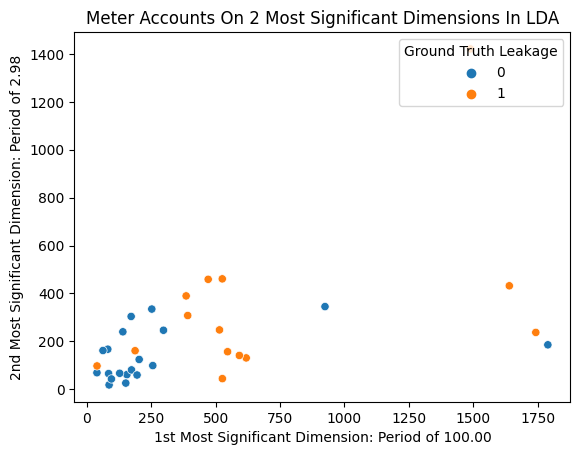

In [181]:
#Plot LDA with Scatter Plot of Meters
#Define the 2 dimensions
(key1, key2) = df_accounts_pivoted.keys()[ranked_indices_desc[0:2]]

#Create line boundary from LDA
# linemesh = np.meshgrid(np.linspace(0, 500, 500), np.linspace(0,700, 700))
# linemesh = np.swapaxes(linemesh, 0, 2)
# linemesh = np.swapaxes(linemesh, 0, 1)
# linemesh = linemesh.reshape(-1,2)
# line = lda.decision_function(linemesh)

sns.scatterplot(x=df_accounts_pivoted[key1],y=df_accounts_pivoted[key2], hue=y)  #color: y
plt.xlabel(f'1st Most Significant Dimension: Period of {key1:.2f}')
plt.ylabel(f'2nd Most Significant Dimension: Period of {key2:.2f}')
plt.title('Meter Accounts On 2 Most Significant Dimensions In LDA')
plt.legend(title='Ground Truth Leakage', loc='upper right')


## Create per-account ratio of nonzero to zero usage hour count 

In [182]:
# Create UsageRatio col
combined_data['UsageRatio'] = pd.NA

# Iterate over account numbers
for num in combined_data['AccountNumber'].unique():
    # Pull data for each account number
    subset = combined_data[combined_data['AccountNumber'] == num]
    
    # Count values for each condition
    non_zero_count = (subset['Value'] > 0).sum()
    zero_count = (subset['Value'] == 0).sum()
    
    # Calculate usage ratio (nonzero-to-zero)
    usage_ratio = non_zero_count / zero_count if zero_count != 0 else pd.NA
    combined_data.loc[combined_data['AccountNumber'] == num, 'UsageRatio'] = usage_ratio

combined_data

,AccountNumber,UsageDate,Value,MeterNumber,Class,UsageRatio
0,0050005-28920,01-01-2023 00:00,2,0050005-10450-1,0,0.101412
1,0050005-28920,01-01-2023 01:00,0,0050005-10450-1,0,0.101412
2,0050005-28920,01-01-2023 02:00,0,0050005-10450-1,0,0.101412
3,0050005-28920,01-01-2023 03:00,0,0050005-10450-1,0,0.101412
4,0050005-28920,01-01-2023 04:00,0,0050005-10450-1,0,0.101412
...,...,...,...,...,...,...
299163,5751740-68085,12-31-2022 19:00,1,5751740-10450-1,1,9.37798
299164,5751740-68085,12-31-2022 20:00,0,5751740-10450-1,1,9.37798
299165,5751740-68085,12-31-2022 21:00,1,5751740-10450-1,1,9.37798
299166,5751740-68085,12-31-2022 22:00,2,5751740-10450-1,1,9.37798


In [183]:
combined_data

,AccountNumber,UsageDate,Value,MeterNumber,Class,UsageRatio
0,0050005-28920,01-01-2023 00:00,2,0050005-10450-1,0,0.101412
1,0050005-28920,01-01-2023 01:00,0,0050005-10450-1,0,0.101412
2,0050005-28920,01-01-2023 02:00,0,0050005-10450-1,0,0.101412
3,0050005-28920,01-01-2023 03:00,0,0050005-10450-1,0,0.101412
4,0050005-28920,01-01-2023 04:00,0,0050005-10450-1,0,0.101412
...,...,...,...,...,...,...
299163,5751740-68085,12-31-2022 19:00,1,5751740-10450-1,1,9.37798
299164,5751740-68085,12-31-2022 20:00,0,5751740-10450-1,1,9.37798
299165,5751740-68085,12-31-2022 21:00,1,5751740-10450-1,1,9.37798
299166,5751740-68085,12-31-2022 22:00,2,5751740-10450-1,1,9.37798


In [184]:
# #Create simulated data
# combined_data_0 = combined_data.loc[combined_data['Class'] == 0]

In [185]:
# combined_data_0['Class'] = [1 for _ in range(len(combined_data_0))]

In [186]:
# combined_data_0

In [187]:
# #Leakage simulation with given rate
# def create(data, rate):
#     inv_rate = int(1/rate)
#     signals = []
#     print(inv_rate)
#     for i in range(len(data)):
#         if (i+1) % inv_rate == 0:
#             signals.append(1)
#         else:
#             signals.append(0)
#     return signals

In [188]:
# rate = 0.2
# combined_data_0['Value'] = create(combined_data_0, rate)
# combined_data_0[:10]

In [189]:
# # add suffix to each account number
# combined_data_0['AccountNumber'] = combined_data_0['AccountNumber'].astype(str) + "-1"
# combined_data_0

In [196]:
# Combine real data with simulated data
# final_combined = pd.concat([combined_data, combined_data_0])  
final_combined = combined_data
len(final_combined['AccountNumber'].unique())

33

In [197]:
#truncate each account number to have same length = threshold
LEN_THRES = 7500
df_account_list = [final_combined[final_combined['AccountNumber'] == number].tail(LEN_THRES) for number in final_combined['AccountNumber'].unique()]
for (idx, df_account) in enumerate(df_account_list):
    if (len(df_account) < LEN_THRES):  #remove account if total number of datapoints below threshold
        dropping_meter_number = df_account.loc[:].reset_index()['MeterNumber'][0]
        final_combined = final_combined.drop(final_combined[final_combined['MeterNumber']==dropping_meter_number].index)
        del df_account_list[idx]
# [len(e) for e in df_account_list]  #display number of data points for each account

In [198]:
#need to run the above block before running this one!!

#list to store pivoted account dataframes
df_account_pivoted_list = []

#conduct fourier transfor on each account
for (idx, df_account) in enumerate(df_account_list):
    df_account['FFT_F'] = fftfreq(len(df_account), 1)
    df_account['FFT_Period'] = 1/df_account['FFT_F']
    df_account['FFT'] = fft(df_account['Value'])
    df_account['FFTA'] = np.abs(df_account['FFT'])

    #only keep periods from 0 to 30
    df_account = df_account.where(df_account['FFT_Period'] <= 100)
    df_account = df_account.where(df_account['FFT_Period'] >= 0)
    df_account = df_account.dropna()
    df_account_list[idx] = df_account

    #pivot each account dataframe
    df_account_pivoted = df_account.pivot(index="AccountNumber", columns='FFT_Period', values='FFTA')
    df_account_pivoted_list.append(df_account_pivoted)

# df_account_pivoted_list[0]  #this shows 0 na's in dataframe


In [199]:
# combine all pivoted account dataframes
df_accounts_pivoted = pd.concat(df_account_pivoted_list)

# merge with stored usage ratios
df_accounts_pivoted = pd.merge(df_accounts_pivoted, usage_ratio_vals, on='AccountNumber', how='left')
#df_account_pivoted = pd.concat(usage_ratio_vals)

df_accounts_pivoted

,AccountNumber,2.0005334755934916,2.0010672358591246,2.00160128102482,2.00213561131874,2.0026702269692924,2.003205128205128,2.003740315255143,2.0042757883484765,2.0048115477145148,...,90.36144578313252,91.46341463414635,92.59259259259258,93.74999999999999,94.9367088607595,96.15384615384615,97.4025974025974,98.68421052631578,100.0,UsageRatio
0,0050005-28920,124.149343,158.141899,64.938147,77.601700,42.662195,32.741850,56.084477,78.939669,116.762542,...,104.957595,43.834491,102.684282,90.876485,146.693388,51.579530,105.280971,122.650629,86.775234,0.101412
1,0050015-328466,93.004434,141.689065,73.804858,223.741081,35.797403,180.564034,243.925734,180.280827,67.842767,...,248.921533,213.615960,250.737992,197.550897,254.693141,335.139920,116.371322,358.334267,203.500673,0.469786
2,0050017-668118,120.551459,67.625835,167.578027,64.648633,132.422852,92.543808,146.455887,29.508063,119.969151,...,83.620470,204.722682,37.571468,145.696681,103.068668,108.187932,52.343712,120.073422,155.942757,0.469227
3,0050020-660260,385.779023,315.186462,171.289129,66.388887,133.261003,91.737888,18.871754,71.030641,116.514351,...,46.249502,104.733059,167.594885,55.567388,148.105564,105.135365,9.849864,45.410118,81.773654,0.310706
4,0050100-50430,95.891447,48.473892,61.564863,107.176587,42.742959,142.269649,118.328452,206.675077,35.331375,...,391.669726,159.600859,27.998063,348.113851,241.849429,342.237139,211.462591,572.913887,84.952839,0.721866
5,0050110-26,1523.172081,283.062982,419.868545,375.451790,1019.443900,252.327860,295.287807,252.288357,289.774121,...,97.696750,102.147522,41.457818,32.504402,41.078043,42.917868,65.423987,68.802533,62.993596,0.034248
6,0050180-66814,108.052711,76.353429,71.778807,30.874499,34.146556,64.364508,97.605455,79.815960,69.003109,...,29.727940,86.913121,5.484606,51.062073,35.675575,113.657695,77.004387,59.877533,151.600383,0.566655
7,0050200-530518,149.218293,73.624128,107.684366,141.472854,146.548201,135.756501,94.369048,86.328719,83.233575,...,276.193778,75.820755,160.312020,87.572202,106.434551,173.612055,126.166197,96.697488,297.822756,0.747181
8,0050240-149921,651.176825,132.546341,246.136602,138.109439,208.087396,190.033506,179.145157,200.073390,184.662005,...,487.857144,719.759844,834.067319,562.582277,342.950871,562.514354,1369.993470,1474.603359,1789.500664,15.808824
9,0050280-110323,169.861483,182.666323,62.608269,38.004677,34.974053,27.581952,55.569342,23.705484,29.640324,...,114.292938,24.124130,22.188228,87.692786,31.681687,48.843445,44.226528,80.059210,95.788135,0.048809


In [200]:
# Perform LDA
X = np.array(df_accounts_pivoted.iloc[:,[j for j, c in enumerate(df_accounts_pivoted.columns) if j != 0]])
y = np.array([final_combined.loc[final_combined['AccountNumber'] == meter_number].reset_index()['Class'][0] for meter_number in final_combined['AccountNumber'].unique()])

# X.shape, y.shape
X[-1]
# 

array([7433.878208899062, 2796.095411283285, 2595.931374171583, ...,
       836.1300411862218, 1488.9246235374953, 9.377979568671964],
      dtype=object)

In [201]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=38)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.9166666666666666
Confusion Matrix:
[[7 1]
 [0 4]]
